## Imports & Preconditions

In [108]:
from sklearn.metrics import recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import warnings

In [16]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")

N_JOBS= 8
RSEED = 12345
PRIMARY_SCORE = "f1"
COUNTER_TYPE_MAPPING = {"ELEC": 0, "GAZ": 1}
MAX_FEATURES_PER_ROW = 6
TARGET_LABELS = {0: "Regular", 1: "Fraud"}
COLUMNS_ONE_HOT_ENCODING = [
    "disrict", 
    "region", 
    "client_catg", 
    "tarif_type", 
    "reading_remarque",
	"counter_type", 
    "counter_code", 
    "counter_statue", 
    "counter_coefficient"
]


def evaluate_model(y_true, y_predict, y_predict_proba):
    print(f"F1: {f1_score(y_true, y_predict):.2f}")
    print(f"Recall: {recall_score(y_true, y_predict):.2f}")
    print(f"TNR: {recall_score(y_true, y_predict, pos_label=0):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_predict_proba):.2f}")
    print(confusion_matrix(y_true, y_predict))


def train_and_predict(classifier, X_train, y_train, X_test, y_test, scaler=None):
    if scaler is not None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    classifier.fit(X_train, y_train)
    print("[TRAIN]")
    evaluate_model(y_train, classifier.predict(X_train), classifier.predict_proba(X_train)[:,1])
    print("\n[TEST]")
    evaluate_model(y_test, classifier.predict(X_test), classifier.predict_proba(X_test)[:,1])


def feature_importance(tree, feature_names):
    fig, ax = plt.subplots()
    pd.Series(tree.feature_importances_, index=feature_names).plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

## Client and Invoice data

In [17]:
df_clients = pd.read_csv("data/train/client_train.csv")
df_invoices = pd.read_csv("data/train/invoice_train.csv")

### Clients

- client_id: Unique id for client
- disrict: District where the client is
- region: Area where the client is
- client_catg: Category client belongs to
- creation_date: Date client joined
- target: Fraud: 1, no fraud: 0

In [18]:
display(df_clients)
df_clients.info()
display(df_clients.isnull().sum())

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

### Invoices

- client_id: Unique id for the client
- invoice_date: Date of the invoice
- tarif_type: Type of tax
- counter_number: Counter number
- counter_statue: Takes up to 5 values such as working fine, not working, on hold statue, ect
- counter_code: Counter codes
- reading_remarque: Notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- consommation_level_1-4: Consumption levels
- old_index: Old index
- new_index: New index
- months_number: Month number
- counter_type: Type of counter

In [19]:
display(df_invoices)
df_invoices.info()
display(df_invoices.isnull().sum())

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

## Data Cleaning & Feature Engineering

In [132]:
df = df_invoices.merge(df_clients, on="client_id")

# Convert target from float to int
df["target"] = df["target"].astype(int)

# Sanitize counter type and status
df["counter_type"] = df["counter_type"].map(COUNTER_TYPE_MAPPING).astype(int)
df["counter_statue"] = df["counter_statue"].replace("A", 10).astype(int)

# Derive consumption from old and new counter indices
df["consumption"] = df["new_index"] - df["old_index"]
# Also derive sum of all consommations
#df["consommation_total"] = df["consommation_level_1"] + df["consommation_level_2"] + df["consommation_level_3"] + df["consommation_level_4"]

# Derive date parts from invoice_date & creation_date
creation_date = pd.to_datetime(df["creation_date"], format="%d/%m/%Y")
invoice_date = pd.to_datetime(df["invoice_date"], format="%Y-%m-%d")

df["creation_date"] = creation_date.dt.strftime("%Y%m%d").astype(int)
df["creation_year"] = creation_date.dt.year
df["creation_month"] = creation_date.dt.month

df["invoice_date"] = creation_date.dt.strftime("%Y%m%d").astype(int)
df["invoice_year"] = creation_date.dt.year
df["invoice_month"] = creation_date.dt.month

"""
df["invoice_month_ts"] = invoice_date.dt.strftime("%Y%m").astype(int)

df_y = df[df["target"] == 0] \
    .groupby("invoice_month_ts") \
    .agg(consumption_mean=("consumption", "mean"), consumption_std=("consumption", "std")) \
    .reset_index()

df = df.merge(df_y, on="invoice_month_ts")
df["consumption_std"] = df["consumption_std"].fillna(0)
df["over_consumption"] = (df["consumption"] - df["consumption_mean"])
"""


'\ndf["invoice_month_ts"] = invoice_date.dt.strftime("%Y%m").astype(int)\n\ndf_y = df[df["target"] == 0]     .groupby("invoice_month_ts")     .agg(consumption_mean=("consumption", "mean"), consumption_std=("consumption", "std"))     .reset_index()\n\ndf = df.merge(df_y, on="invoice_month_ts")\ndf["consumption_std"] = df["consumption_std"].fillna(0)\ndf["over_consumption"] = (df["consumption"] - df["consumption_mean"])\n'

### Dropping rows

In [133]:
# Remove all rows where year < 2005, because there was no fraud detection
# Remove all rows where counter_statue > 5
df = df[(invoice_date.dt.year >= 2005) & (df["counter_statue"] <= 5)]

### Dropping columns

In [134]:
df = df.drop(["client_id", "months_number", "counter_number"], axis=1)

### The resulting dataset

In [135]:
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 4454591 entries, 0 to 4476745
Data columns (total 23 columns):
 #   Column                Dtype
---  ------                -----
 0   invoice_date          int64
 1   tarif_type            int64
 2   counter_statue        int64
 3   counter_code          int64
 4   reading_remarque      int64
 5   counter_coefficient   int64
 6   consommation_level_1  int64
 7   consommation_level_2  int64
 8   consommation_level_3  int64
 9   consommation_level_4  int64
 10  old_index             int64
 11  new_index             int64
 12  counter_type          int64
 13  disrict               int64
 14  client_catg           int64
 15  region                int64
 16  creation_date         int64
 17  target                int64
 18  consumption           int64
 19  creation_year         int32
 20  creation_month        int32
 21  invoice_year          int32
 22  invoice_month         int32
dtypes: int32(4), int64(19)
memory usage: 747.7 MB


,invoice_date,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,counter_type,disrict,client_catg,region,creation_date,target,consumption,creation_year,creation_month,invoice_year,invoice_month
0,19941231,11,0,203,8,1,82,0,0,0,14302,14384,0,60,11,101,19941231,0,82,1994,12,1994,12
1,19941231,11,0,203,6,1,1200,184,0,0,12294,13678,0,60,11,101,19941231,0,1384,1994,12,1994,12
2,19941231,11,0,203,8,1,123,0,0,0,14624,14747,0,60,11,101,19941231,0,123,1994,12,1994,12
3,19941231,11,0,207,8,1,102,0,0,0,14747,14849,0,60,11,101,19941231,0,102,1994,12,1994,12
4,19941231,11,0,207,9,1,572,0,0,0,15066,15638,0,60,11,101,19941231,0,572,1994,12,1994,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476741,20111122,40,0,5,9,1,118,0,0,0,406,524,1,63,11,311,20111122,0,118,2011,11,2011,11
4476742,20111122,11,0,207,9,1,312,0,0,0,2562,2874,0,63,11,311,20111122,0,312,2011,11,2011,11
4476743,20111122,11,0,207,9,1,578,0,0,0,8505,9083,0,63,11,311,20111122,0,578,2011,11,2011,11
4476744,19931222,10,0,202,9,1,400,135,0,0,3197,3732,0,60,11,101,19931222,0,535,1993,12,1993,12


## EDA

### Unique values

In [24]:
for col in df.columns.sort_values():
    print(f"{col}: {np.sort(df[col].unique())}\n")

client_catg: [11 12 51]

consommation_level_1: [     0      1      2 ...  98889 126118 999910]

consommation_level_2: [     0      1      2 ... 785757 819886 999073]

consommation_level_3: [    0     1     2 ... 45360 50695 64492]

consommation_level_4: [     0      1      2 ... 284765 343568 547946]

consumption: [-999025 -998916 -998539 ...  625521  629631  633228]

counter_code: [  5  10  16  25  40  65 101 102 201 202 203 204 207 210 214 222 227 303
 305 307 403 407 410 413 420 433 442 450 453 467 483 506 532 565 600]

counter_coefficient: [ 0  1  2  3  4  5 10 11 20 30 33 40]

counter_statue: [0 1 2 3 4 5]

counter_type: [0 1]

creation_date: [19770205 19770209 19770210 ... 20190821 20190905 20190910]

creation_month: [ 1  2  3  4  5  6  7  8  9 10 11 12]

creation_year: [1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018


### Feature boxplots

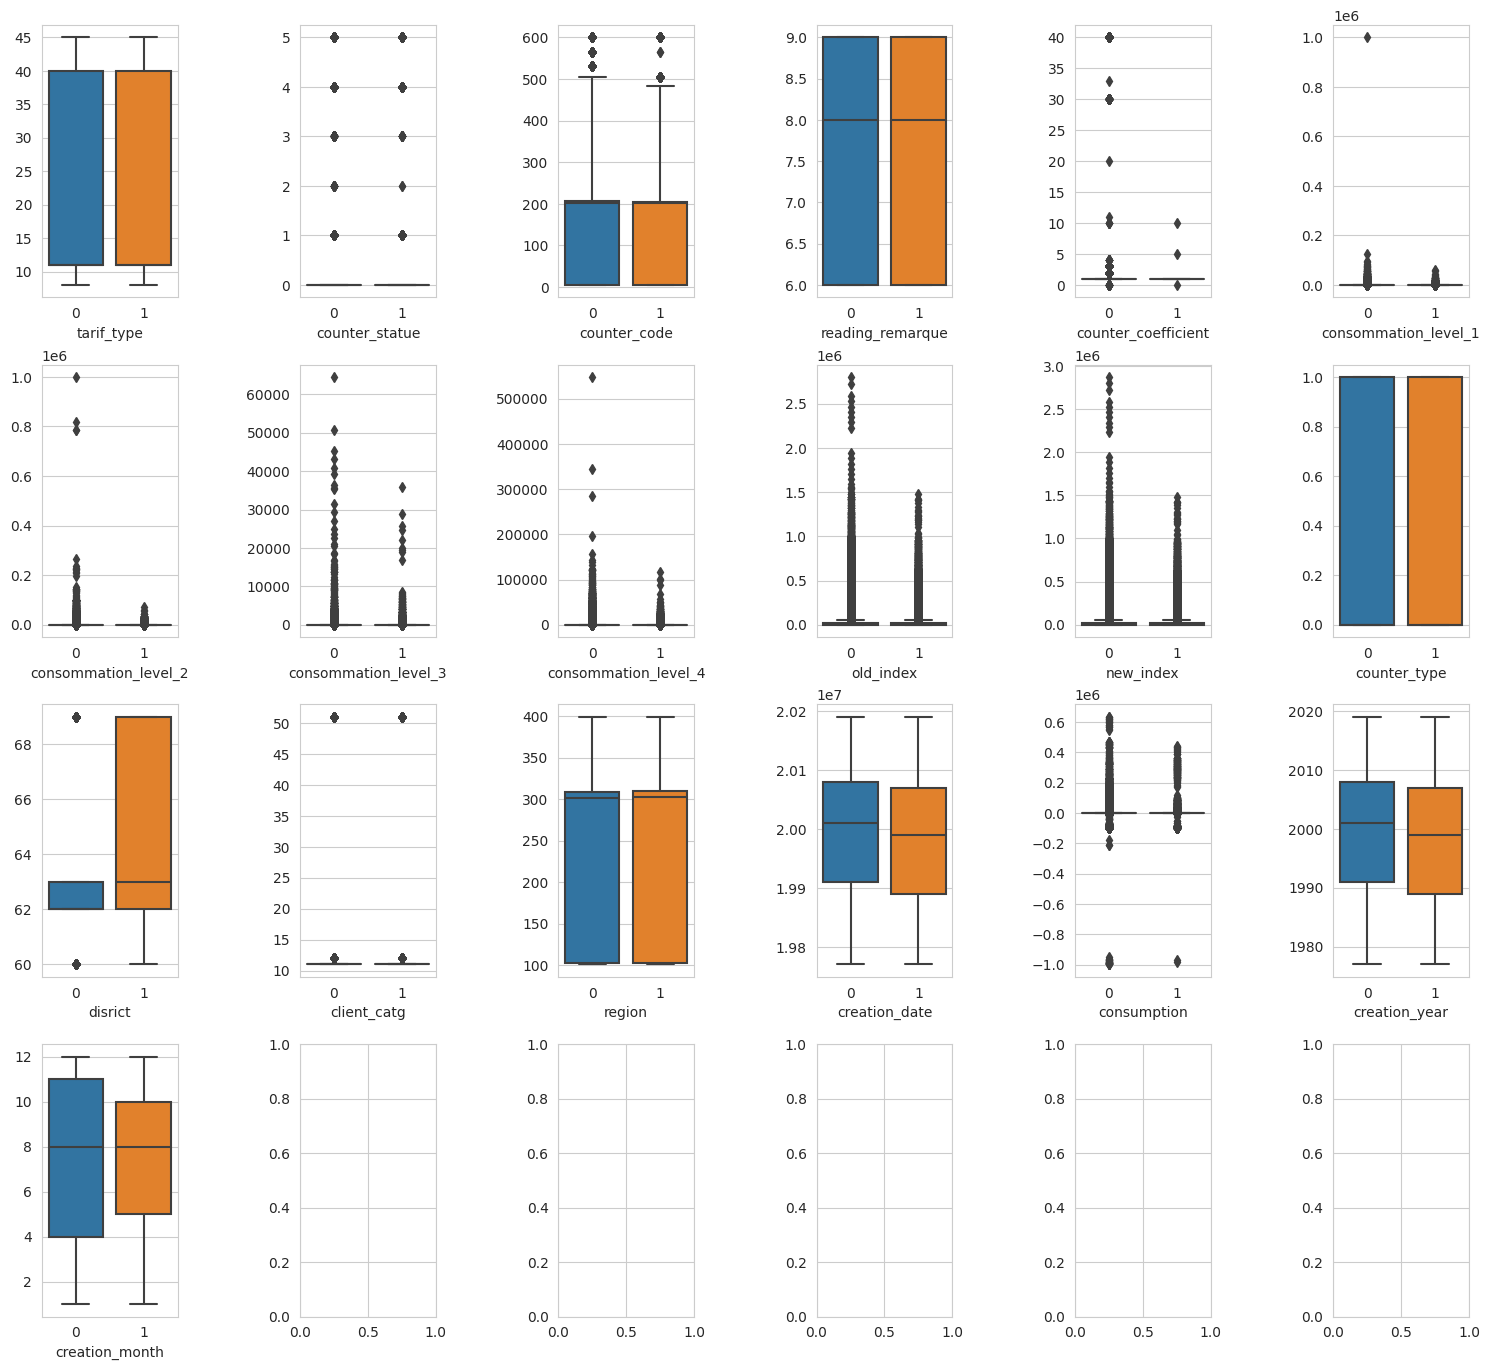

In [25]:
cols = df.columns.drop("target")
nrows = math.ceil(len(cols)/MAX_FEATURES_PER_ROW)
fig, ax = plt.subplots(nrows, MAX_FEATURES_PER_ROW, figsize = (15,15))

for i,col in enumerate(cols):
    nrow = math.floor(i/MAX_FEATURES_PER_ROW)
    ncol = i%MAX_FEATURES_PER_ROW
    f = sns.boxplot(y=df[col], x=df["target"], ax=ax[nrow][ncol])
    f.set_xlabel(col)
    f.set_ylabel(None)

fig.tight_layout()
plt.subplots_adjust(wspace = 0.9, top = 0.9)
plt.show()

### Correlations

<Axes: >

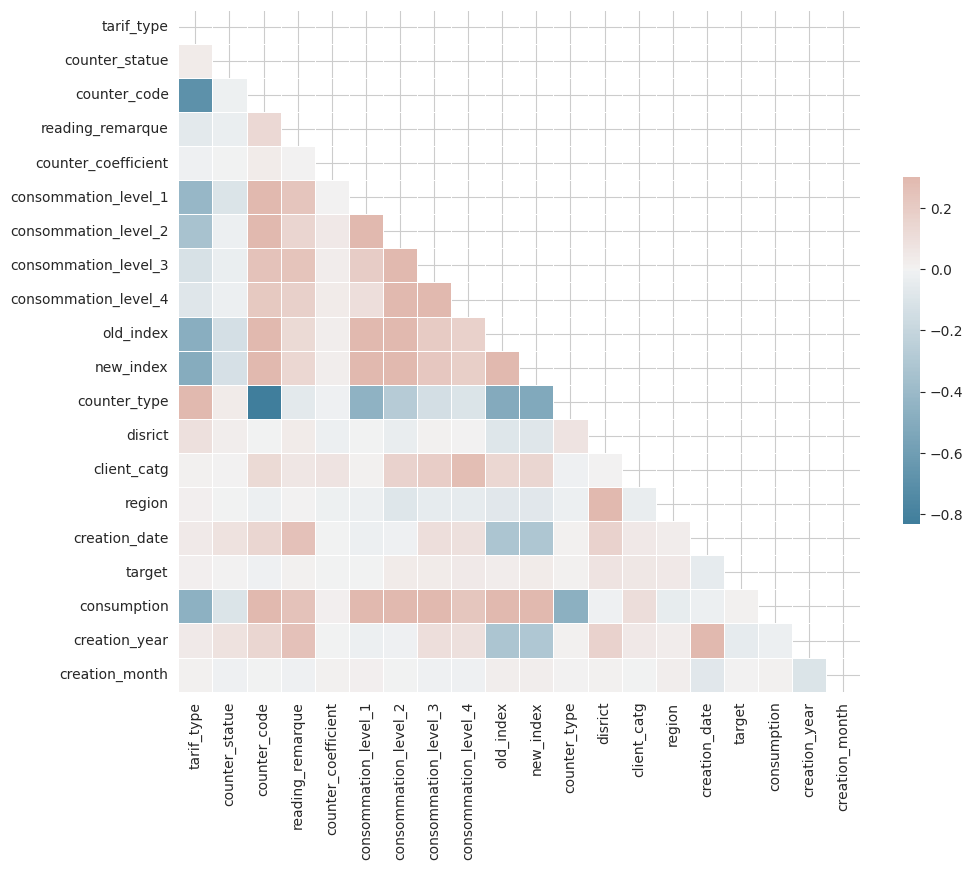

In [26]:
corr = df.corr("spearman")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## One-Hot-Encoding

In [136]:
df = pd.get_dummies(drop_first=True, data=df, columns=COLUMNS_ONE_HOT_ENCODING)

## Splitting & Resampling

In [137]:
y = df["target"]
X = df.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = RSEED)

#sampler = SMOTE(random_state=RSEED, sampling_strategy=0.1)
#X_train, y_train = sampler.fit_resample(X_train, y_train)

## Modeling

### Baseline model: Coin toss

In [29]:
y_pred = np.random.randint(2, size=len(df))
evaluate_model(y, y_pred, y_pred)

F1: 0.14
Recall: 0.50
ROC-AUC: 0.50
[[2048286 2053193]
 [ 176742  176370]]


### Random Forest with 100 estimators

In [30]:
train_and_predict(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RSEED, n_jobs=N_JOBS), 
    X_train, y_train, X_test, y_test
)

[TRAIN]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.70
[[2871035       0]
 [ 246698     480]]

[TEST]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.70
[[1230444       0]
 [ 105763     171]]


### Single Decision Tree

In [138]:
train_and_predict(
    DecisionTreeClassifier(random_state=RSEED), 
    X_train, y_train, X_test, y_test
)

[TRAIN]
F1: 0.99
Recall: 0.99
ROC-AUC: 1.00
[[2870353     682]
 [   3525  243653]]

[TEST]
F1: 0.63
Recall: 0.64
ROC-AUC: 0.81
[[1190166   40278]
 [  38606   67328]]


### Logistic Regression

In [32]:
train_and_predict(
    LogisticRegression(random_state=RSEED, n_jobs=N_JOBS), 
    X_train, y_train, X_test, y_test,
    StandardScaler()
)

[TRAIN]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.65
[[2870651     384]
 [ 246710     468]]

[TEST]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.65
[[1230303     141]
 [ 105710     224]]


### XGBoost

In [33]:
train_and_predict(
    XGBClassifier(random_state=RSEED), 
    X_train, y_train, X_test, y_test
)

[TRAIN]
F1: 0.14
Recall: 0.07
ROC-AUC: 0.78
[[2868691    2344]
 [ 228876   18302]]

[TEST]
F1: 0.13
Recall: 0.07
ROC-AUC: 0.77
[[1229381    1063]
 [  98332    7602]]


### LightGBM


In [34]:
train_and_predict(
    LGBMClassifier(random_state=RSEED, n_jobs=N_JOBS), 
    X_train, y_train, X_test, y_test
)

[LightGBM] [Info] Number of positive: 247178, number of negative: 2871035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 3118213, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079269 -> initscore=-2.452319
[LightGBM] [Info] Start training from score -2.452319
[TRAIN]
F1: 0.04
Recall: 0.02
ROC-AUC: 0.73
[[2870630     405]
 [ 242218    4960]]

[TEST]
F1: 0.04
Recall: 0.02
ROC-AUC: 0.73
[[1230266     178]
 [ 103891    2043]]


### Stochastic Gradient Descent (SGD)

In [35]:
train_and_predict(
    CalibratedClassifierCV(SGDClassifier(max_iter=5, random_state=RSEED, n_jobs=N_JOBS)),
    X_train, y_train, X_test, y_test
)

[TRAIN]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.50
[[2871035       0]
 [ 247178       0]]

[TEST]
F1: 0.00
Recall: 0.00
ROC-AUC: 0.50
[[1230444       0]
 [ 105934       0]]


## Hyperparameter Tuning

### Manual

In [36]:
"""
tree = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_impurity_decrease=0,
    random_state = RSEED
)
scores = cross_val_score(tree, X_train, y_train, cv=5, n_jobs=N_JOBS, scoring=PRIMARY_SCORE)
sns.barplot(x=[1,2,3,4,5], y=scores)
"""

'\ntree = DecisionTreeClassifier(\n    criterion="gini",\n    splitter="best",\n    max_depth=None,\n    max_features=None,\n    max_leaf_nodes=None,\n    min_samples_split=2,\n    min_samples_leaf=1,\n    min_impurity_decrease=0,\n    random_state = RSEED\n)\nscores = cross_val_score(tree, X_train, y_train, cv=5, n_jobs=N_JOBS, scoring=PRIMARY_SCORE)\nsns.barplot(x=[1,2,3,4,5], y=scores)\n'

### Automatic

In [37]:
"""
param_grid = {
    "max_depth": [None, 5, 10, 20, 50, 100],
    "max_features": ["auto", "sqrt", None],
    "max_leaf_nodes": [None, 5, 10, 20, 50, 100],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3],
    "min_impurity_decrease": [0, 0.01, 0.1]
}

estimator = DecisionTreeClassifier(random_state = RSEED)

rs = RandomizedSearchCV(estimator, param_grid, n_jobs = N_JOBS, 
                        scoring = PRIMARY_SCORE, cv = 2, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)
print(rs.best_params_)

y_train_pred = rs.best_estimator_.predict(X_train)
y_train_proba_pred = rs.best_estimator_.predict_proba(X_train)[:, 1]

y_test_pred = rs.best_estimator_.predict(X_test)
y_test_proba_pred = rs.best_estimator_.predict_proba(X_test)[:, 1]

print("TRAIN:")
evaluate_model(y_train, y_train_pred, y_train_proba_pred)

print("\nTEST:")
evaluate_model(y_test, y_test_pred, y_test_proba_pred)
"""

'\nparam_grid = {\n    "max_depth": [None, 5, 10, 20, 50, 100],\n    "max_features": ["auto", "sqrt", None],\n    "max_leaf_nodes": [None, 5, 10, 20, 50, 100],\n    "min_samples_split": [2, 5, 10],\n    "min_samples_leaf": [1, 2, 3],\n    "min_impurity_decrease": [0, 0.01, 0.1]\n}\n\nestimator = DecisionTreeClassifier(random_state = RSEED)\n\nrs = RandomizedSearchCV(estimator, param_grid, n_jobs = N_JOBS, \n                        scoring = PRIMARY_SCORE, cv = 2, \n                        n_iter = 10, verbose = 5, random_state=RSEED)\n\nrs.fit(X_train, y_train)\nprint(rs.best_params_)\n\ny_train_pred = rs.best_estimator_.predict(X_train)\ny_train_proba_pred = rs.best_estimator_.predict_proba(X_train)[:, 1]\n\ny_test_pred = rs.best_estimator_.predict(X_test)\ny_test_proba_pred = rs.best_estimator_.predict_proba(X_test)[:, 1]\n\nprint("TRAIN:")\nevaluate_model(y_train, y_train_pred, y_train_proba_pred)\n\nprint("\nTEST:")\nevaluate_model(y_test, y_test_pred, y_test_proba_pred)\n'

## Tests

In [51]:
df_x = df_invoices.merge(df_clients, on="client_id")
creation_date = pd.to_datetime(df_x["creation_date"], format="%d/%m/%Y")
invoice_date = pd.to_datetime(df_x["invoice_date"], format="%Y-%m-%d")

df_x["target"] = df_x["target"].astype(int)
df_x["counter_type"] = df_x["counter_type"].map(COUNTER_TYPE_MAPPING).astype(int)
df_x["counter_statue"] = df_x["counter_statue"].replace("A", 10).astype(int)
df_x["consumption"] = df_x["new_index"] - df_x["old_index"]
df_x["consommation_total"] = df_x["consommation_level_1"] + df_x["consommation_level_2"] + df_x["consommation_level_3"] + df_x["consommation_level_4"]

df_x["invoice_date"] = invoice_date.dt.strftime("%Y%m%d").astype(int)
df_x["invoice_year"] = invoice_date.dt.year
df_x["invoice_month"] = invoice_date.dt.month
df_x["invoice_month_ts"] = invoice_date.dt.strftime("%Y%m").astype(int)

df_x["creation_date"] = creation_date.dt.strftime("%Y%m%d").astype(int)
df_x["creation_year"] = creation_date.dt.year
df_x["creation_month"] = creation_date.dt.month

df_x = df_x[(invoice_date.dt.year >= 2005) & (df_x["counter_statue"] <= 5)]

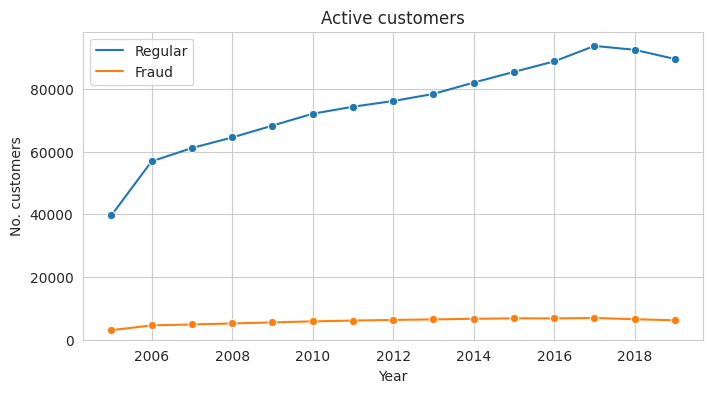

In [39]:
df_y = df_x \
    .groupby(["invoice_year", "target"]) \
    .agg(customers=("client_id", "nunique")) \
    .reset_index()

df_y["target"] = df_y["target"].map(TARGET_LABELS).astype(str)

plt.figure(figsize=(8,4))

ax = sns.lineplot(df_y, x="invoice_year", y="customers", hue="target", marker="o")
ax.set_ylim(0, None)

plt.legend(title=None)
plt.title("Active customers")
plt.xlabel("Year")
plt.ylabel("No. customers")
plt.show()

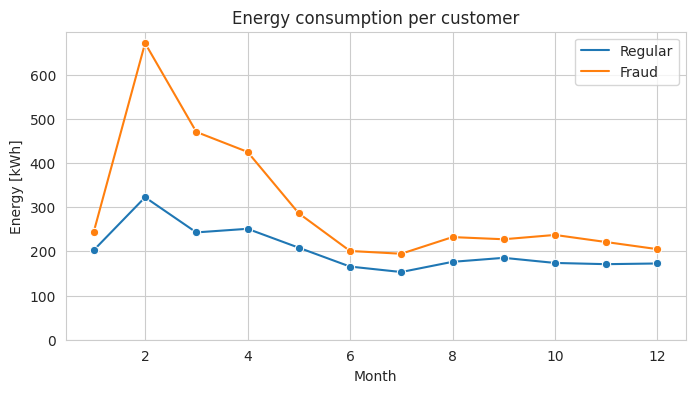

In [45]:
df_y = df_x \
    .groupby(["invoice_month", "target"]) \
    .agg(
        consumption=("consumption", "sum"), 
        customers=("client_id", "nunique"),
        invoice_months=("invoice_month_ts", "nunique")) \
    .reset_index()

df_y["consumption"] = df_y["consumption"]/(df_y["customers"]*df_y["invoice_months"])
df_y["target"] = df_y["target"].map(TARGET_LABELS).astype(str)

plt.figure(figsize=(8,4))

ax = sns.lineplot(df_y, x="invoice_month", y="consumption", hue="target", marker="o")
ax.set_ylim(0, None)

plt.legend(title=None)
plt.title("Energy consumption per customer")
plt.xlabel("Month")
plt.ylabel("Energy [kWh]")
plt.show()

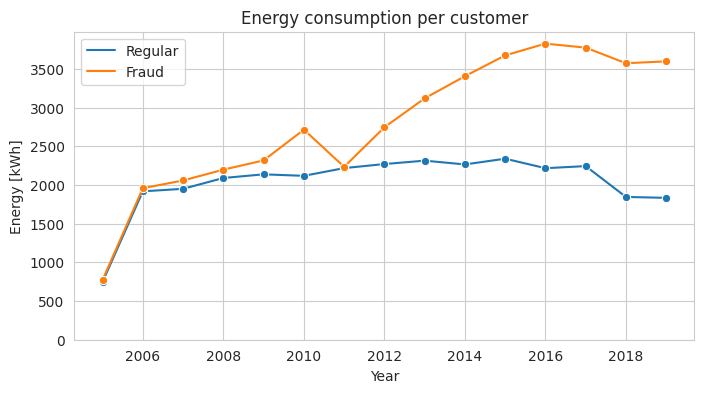

In [41]:
df_y = df_x \
    .groupby(["invoice_year", "target"]) \
    .agg(
        consumption=("consumption", "sum"), 
        customers=("client_id", "nunique")
    ) \
    .reset_index()

df_y["consumption"] = df_y["consumption"]/df_y["customers"]
df_y["target"] = df_y["target"].map(TARGET_LABELS).astype(str)

plt.figure(figsize=(8,4))

ax = sns.lineplot(df_y, x="invoice_year", y="consumption", hue="target", marker="o")
ax.set_ylim(0, None)

plt.legend(title=None)
plt.title("Energy consumption per customer")
plt.xlabel("Year")
plt.ylabel("Energy [kWh]")
plt.show()

In [53]:
df_y = df_x[df_x["target"] == 0] \
    .groupby("invoice_month_ts") \
    .agg(consumption_mean=("consommation_total", "mean"), consumption_std=("consommation_total", "std")) \
    .reset_index()

display(df_x)

df_z = df_x.merge(df_y, on="invoice_month_ts")

display(df_z)

"""
df_x["consumption_mean"] = df_x[df_x["target"] == 0].groupby("invoice_month_ts")["consumption"].transform("mean")
df_x["consumption_std"] = df_x[df_x["target"] == 0].groupby("invoice_month_ts")["consumption"].transform("std")
"""
#display(df_x[df_x["target"] == 1])


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target,consumption,consommation_total,invoice_year,invoice_month,invoice_month_ts,creation_year,creation_month
0,train_Client_0,20140324,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,60,11,101,19941231,0,82,82,2014,3,201403,1994,12
1,train_Client_0,20130329,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,60,11,101,19941231,0,1384,1384,2013,3,201303,1994,12
2,train_Client_0,20150323,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,60,11,101,19941231,0,123,123,2015,3,201503,1994,12
3,train_Client_0,20150713,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,60,11,101,19941231,0,102,102,2015,7,201507,1994,12
4,train_Client_0,20161117,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,60,11,101,19941231,0,572,572,2016,11,201611,1994,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476741,train_Client_99997,20140217,40,0,0,5,9,1,118,0,0,0,406,524,4,1,63,11,311,20111122,0,118,118,2014,2,201402,2011,11
4476742,train_Client_99997,20140613,11,262195,0,207,9,1,312,0,0,0,2562,2874,4,0,63,11,311,20111122,0,312,312,2014,6,201406,2011,11
4476743,train_Client_99997,20191106,11,262195,0,207,9,1,578,0,0,0,8505,9083,4,0,63,11,311,20111122,0,578,578,2019,11,201911,2011,11
4476744,train_Client_99998,20050819,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,0,60,11,101,19931222,0,535,535,2005,8,200508,1993,12


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target,consumption,consommation_total,invoice_year,invoice_month,invoice_month_ts,creation_year,creation_month,consumption_mean,consumption_std
0,train_Client_0,20140324,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,60,11,101,19941231,0,82,82,2014,3,201403,1994,12,614.706578,1767.590165
1,train_Client_100000,20140321,40,50838,0,5,9,1,412,0,0,0,2768,3180,4,1,62,11,309,20120607,0,412,412,2014,3,201403,2012,6,614.706578,1767.590165
2,train_Client_100000,20140321,11,38089,0,413,8,1,497,0,0,0,34818,35315,4,0,62,11,309,20120607,0,497,497,2014,3,201403,2012,6,614.706578,1767.590165
3,train_Client_10001,20140314,11,81533,0,413,9,1,800,403,0,0,26968,28171,4,0,63,11,312,20020514,0,1203,1203,2014,3,201403,2002,5,614.706578,1767.590165
4,train_Client_10001,20140314,40,102258,0,5,6,1,247,0,0,0,11865,12112,4,1,63,11,312,20020514,0,247,247,2014,3,201403,2002,5,614.706578,1767.590165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454586,train_Client_99920,20050727,11,625529,0,203,6,1,281,0,0,0,1681,1962,4,0,60,11,101,20020308,0,281,281,2005,7,200507,2002,3,482.100804,952.404471
4454587,train_Client_99945,20050728,11,1278367,0,203,6,1,109,0,0,0,9144,9253,2,0,60,11,101,19940419,0,109,109,2005,7,200507,1994,4,482.100804,952.404471
4454588,train_Client_99958,20050707,40,54976,0,5,6,1,59,0,0,0,884,943,4,1,60,11,101,20011224,0,59,59,2005,7,200507,2001,12,482.100804,952.404471
4454589,train_Client_99958,20050707,11,587237,0,203,6,1,326,0,0,0,4541,4867,4,0,60,11,101,20011224,0,326,326,2005,7,200507,2001,12,482.100804,952.404471


'\ndf_x["consumption_mean"] = df_x[df_x["target"] == 0].groupby("invoice_month_ts")["consumption"].transform("mean")\ndf_x["consumption_std"] = df_x[df_x["target"] == 0].groupby("invoice_month_ts")["consumption"].transform("std")\n'

# months_number <= 100 and > 0
# consumption > 0
# Device by electricity / gas
